<a href="https://colab.research.google.com/github/enugalamanideepreddy/ScoreMNIST/blob/main/score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Data

In [2]:
# Define transformation (e.g., convert to tensor)
transform = transforms.ToTensor()

# Download and load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine train and test datasets
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

ind = [i for i in range(len(dataset)) if dataset[i][1] == 3]

dataset = torch.utils.data.Subset(dataset, ind)

# Wrap the combined dataset with DataLoader for batching
dataloader = torch.utils.data.DataLoader(dataset = dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


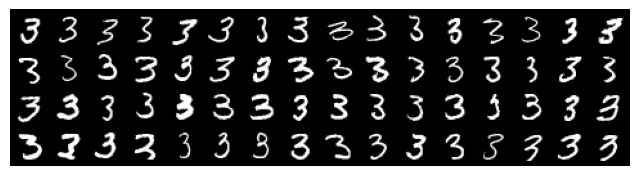

In [3]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Create a grid of images
grid = utils.make_grid(images, nrow=16, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
plt.axis('off')
plt.show()

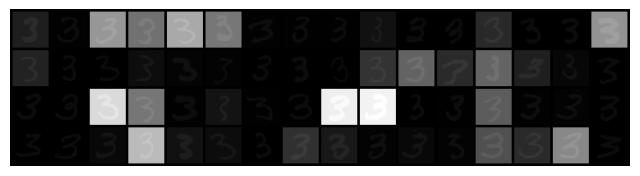

In [5]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(dataloader))

# Get a batch of images and labels
imgs = images

for i in range(len(imgs)):
  t = np.random.uniform(0, 1)
  imgs[i] += get_noise(t)

# Create a grid of images
grid = utils.make_grid(imgs, nrow=16, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
plt.axis('off')
plt.show()

## Model

## Multiple Noise Perturbations

In [6]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        # x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        x2 = x
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        # signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

In [7]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, nch) is the training data

    t_i = torch.linspace(0,1,1000,dtype=x.dtype, device=x.device)

    # sample the time
    t = t_i[torch.randint(0, len(t_i), (x.shape[0],1))]
    z = torch.randn(x.shape, dtype=x.dtype, device=x.device)

    var_t = 0.01*(100)**t
    x_t = x + (var_t**0.5)[...,None,None]*z

    # calculate the score function
    score = score_network(x_t, t)  # score: (batch_size, nch)

    # calculate the loss function
    loss = (score + z*((1/var_t)[...,None,None])) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t[...,None,None] * loss
    return torch.mean(weighted_loss)

In [8]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda:0')  # change this if you don't have a gpu
score_network = score_network.to(device)
t0 = time.time()
for i_epoch in range(400):
    total_loss = 0
    for data, _ in dloader:  # we don't need the data class
        data = data.to(device)
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 20 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dataset)}")

0 (3.372507095336914s): 20.87008996457884
20 (42.36965894699097s): 4.094873556919149
40 (80.78603744506836s): 2.702874931329573
60 (119.16080045700073s): 2.3263065388616337
80 (157.3222463130951s): 2.1374490704961793
100 (196.43844747543335s): 2.0315782088990337
120 (234.90277075767517s): 2.000863871810116
140 (273.12345814704895s): 1.8729906384642092
160 (311.4570620059967s): 1.8806341931760153
180 (349.7331829071045s): 1.8557194160356723
200 (388.44605255126953s): 1.7950669894480868
220 (426.7257363796234s): 1.7417752467990004
240 (465.28452372550964s): 1.6762924396996737
260 (503.5674321651459s): 1.736890577932747
280 (541.8877465724945s): 1.6981777419330792
300 (580.4984982013702s): 1.672163142474855
320 (618.746767282486s): 1.6439815375037328
340 (657.0324323177338s): 1.6846932643535941
360 (695.3998026847839s): 1.6245614900223064
380 (734.2560274600983s): 1.563883329202374


In [9]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 1, 28 , 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    var_t = 0.01*(100)**time_pts
    for i in range(len(time_pts) - 1):
        t = time_pts[i]

        # calculate the drift and diffusion terms
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()

        # x_t = x_t + (0.01/(i+1)) * score + ((2*(0.01/(i+1)))**0.5)*torch.randn_like(x_t, device = device)
        x_t = x_t + 0.2*(var_t[i]/10) * score + ((2*0.2*(var_t[i]/10))**0.5)*torch.randn_like(x_t, device = device)
    return x_t

In [10]:
samples = generate_samples(score_network, 20).detach().reshape(-1, 28, 28)

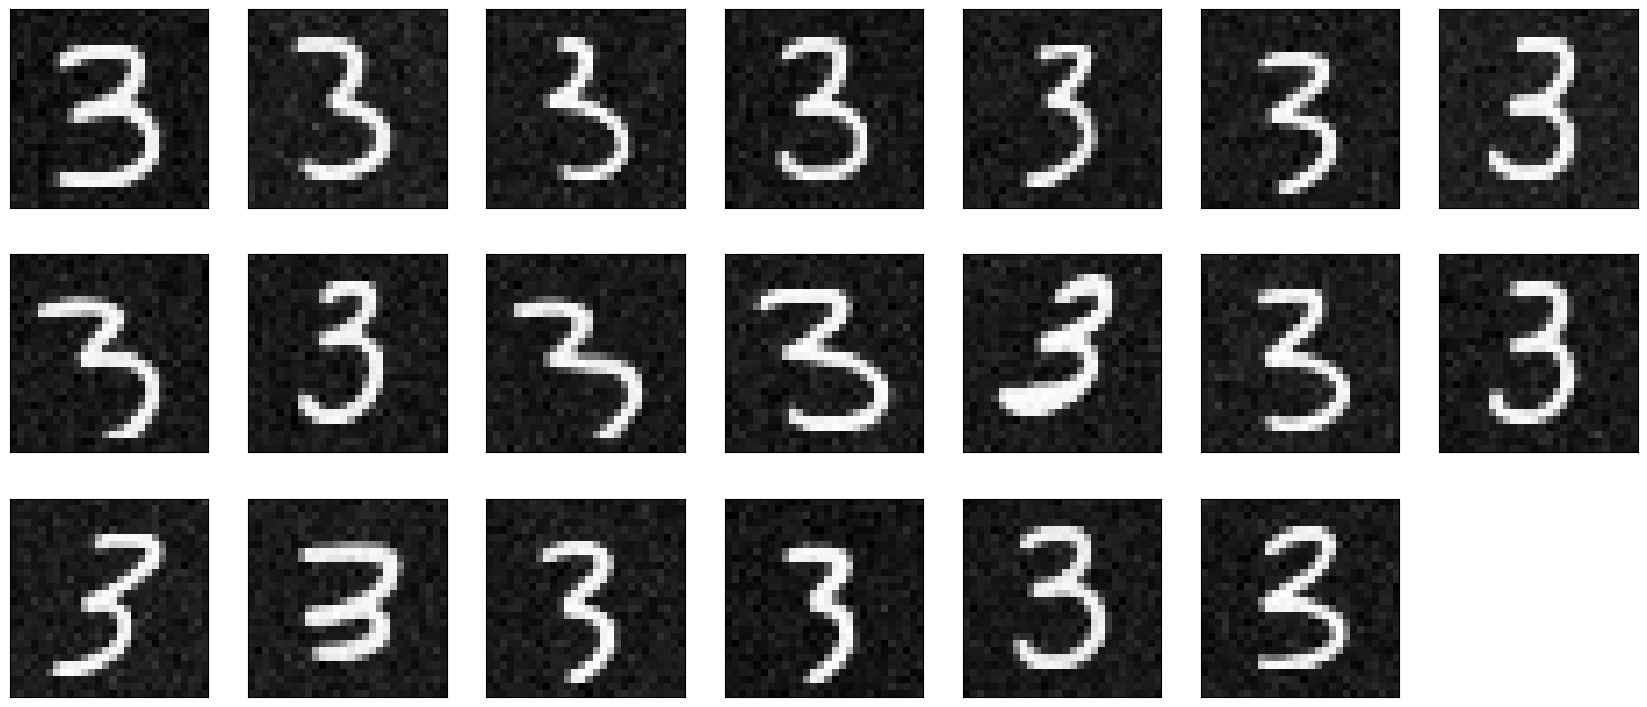

In [11]:
nrows, ncols = 3, 7
plt.figure(figsize=(3 * ncols, 3 * nrows))
for i in range(samples.shape[0]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(1 - samples[i].detach().cpu().numpy(), cmap="Greys")
    plt.xticks([])
    plt.yticks([])

In [12]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 1, 28 , 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    var_t = 0.01*(100)**time_pts
    frames = []
    frames.append(x_t.detach().cpu())
    for i in range(len(time_pts) - 1):
        t = time_pts[i]

        # calculate the drift and diffusion terms
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()

        x_t = x_t + 0.2*(var_t[i]/10) * score + ((2*0.2*(var_t[i]/10))**0.5)*torch.randn_like(x_t, device = device)
        frames.append(x_t.detach().cpu())
    return frames

frames = generate_samples(score_network, 1)

fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis for a cleaner display

ims = []
for frame in frames[::10]:
    # Add each frame to the animation; use `cmap='gray'` for grayscale images
    im = ax.imshow(frame.reshape((28,28)), animated=True, cmap='gray')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.close(fig)  # Prevent immediate display

# Display the animation in the notebook
HTML(ani.to_html5_video())

## SDE

In [ ]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

In [ ]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, nch) is the training data

    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, nch)

    # calculate the score function
    score = score_network(x_t, t)  # score: (batch_size, nch)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)

In [ ]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda:0')  # change this if you don't have a gpu
score_network = score_network.to(device)
t0 = time.time()
for i_epoch in range(400):
    total_loss = 0
    for data, _ in dloader:  # we don't need the data class
        data = data.reshape(data.shape[0], -1).to(device)
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 20 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dataset)}")

0 (2.0587589740753174s): 0.5663341862086805
20 (41.65686774253845s): 0.08066993690750676
40 (84.38984990119934s): 0.05596558454380894
60 (128.80197739601135s): 0.04369385338048903
80 (168.5089464187622s): 0.03662250746193344
100 (207.75808548927307s): 0.034499258805625065
120 (247.10850930213928s): 0.029869739727873944
140 (286.30004024505615s): 0.02751964161493601
160 (325.58050298690796s): 0.02860925995395633
180 (364.7221636772156s): 0.025647608608428945
200 (403.9108991622925s): 0.02555355510822182
220 (443.18939304351807s): 0.024977747916949927
240 (482.31398940086365s): 0.025675412360304895
260 (521.3210492134094s): 0.02192774154543209
280 (560.4536099433899s): 0.023362248112050954
300 (599.7601048946381s): 0.023086831426179354
320 (638.757161617279s): 0.022632636185675473
340 (677.655357837677s): 0.02180641007013259
360 (716.7229347229004s): 0.022230441462806234
380 (756.1721038818359s): 0.021236823131994795


In [ ]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 28 * 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

In [ ]:
samples = generate_samples(score_network, 20).detach().reshape(-1, 28, 28)

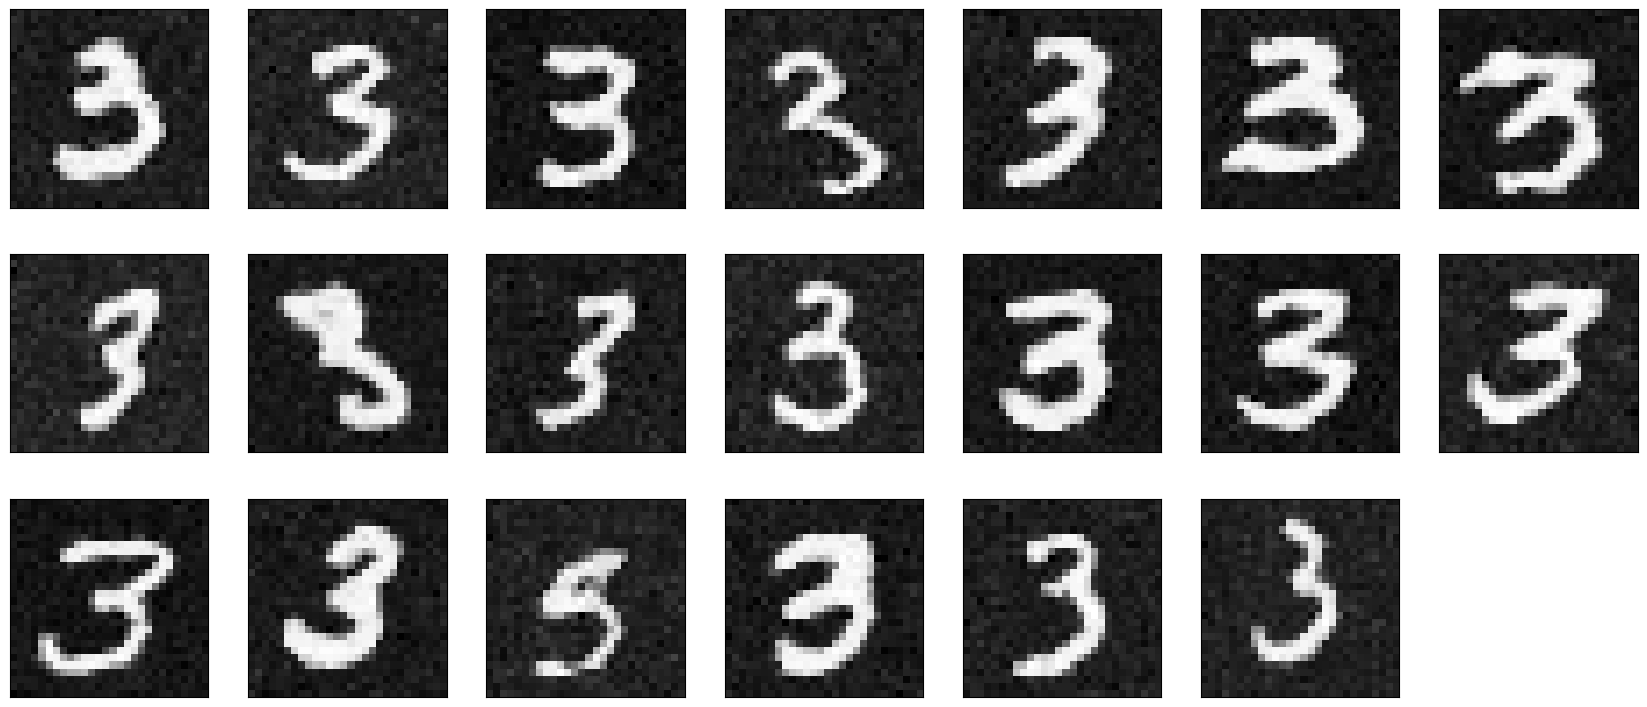

In [ ]:
nrows, ncols = 3, 7
plt.figure(figsize=(3 * ncols, 3 * nrows))
for i in range(samples.shape[0]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(1 - samples[i].detach().cpu().numpy(), cmap="Greys")
    plt.xticks([])
    plt.yticks([])

In [ ]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 28 * 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    frames = []
    frames.append(x_t.detach().cpu())
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5

        frames.append(x_t.detach().cpu())

    return frames

fig, ax = plt.subplots()
ax.axis('off')  # Turn off the axis for a cleaner display

ims = []
for frame in frames[::10]:
    # Add each frame to the animation; use `cmap='gray'` for grayscale images
    im = ax.imshow(1 - frame.reshape((28,28)), animated=True, cmap='gray')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.close(fig)  # Prevent immediate display

# Display the animation in the notebook
HTML(ani.to_html5_video())